In [2]:
import os
import cv2
import fitz  # PyMuPDF
import logging

# Настройка логирования
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("processing_log.log"),
        logging.StreamHandler()
    ]
)

# Папки для работы
input_folder = r"C:\Users\ivan\WORK\particles\class_new"
output_folder = os.path.join(input_folder, r"C:\Users\ivan\WORK\particles\class_png_new")
os.makedirs(output_folder, exist_ok=True)


def process_pdfs_with_fitz(folder):
    logging.info(f"Начало обработки PDF в папке: {folder}")
    for file in os.listdir(folder):
        #if "Дендритная" or  in file and file.endswith(".pdf"):
        logging.info(f"Обработка файла: {file}")
        file_path = os.path.join(folder, file)
        try:
            doc = fitz.open(file_path)
            # Извлекаем только первую страницу
            page = doc[0]  # Первая страница (индекс 0)
            pix = page.get_pixmap(dpi=300)  # Конвертируем в изображение с DPI=300
            temp_image_path = os.path.join(output_folder, f"{os.path.splitext(file)[0]}_page_0.png")
            pix.save(temp_image_path)
            
            # Проверяем, существует ли файл
            if not os.path.exists(temp_image_path):
                logging.error(f"Не удалось сохранить изображение страницы: {temp_image_path}")
                continue
            
            logging.info(f"Первая страница сохранена как изображение: {temp_image_path}")
            
        except Exception as e:
            logging.error(f"Ошибка при обработке файла {file}: {e}")

# Запуск обработки
try:
    process_pdfs_with_fitz(input_folder)
    logging.info("Обработка завершена успешно.")
except Exception as e:
    logging.critical(f"Критическая ошибка во время обработки: {e}")


2024-12-20 17:31:59,180 - INFO - Начало обработки PDF в папке: C:\Users\ivan\WORK\particles\class_new
2024-12-20 17:31:59,181 - INFO - Обработка файла: AL Брызгообразная.pdf
2024-12-20 17:32:00,017 - INFO - Первая страница сохранена как изображение: C:\Users\ivan\WORK\particles\class_png_new\AL Брызгообразная_page_0.png
2024-12-20 17:32:00,018 - INFO - Обработка файла: AL Дендритная.pdf
2024-12-20 17:32:00,727 - INFO - Первая страница сохранена как изображение: C:\Users\ivan\WORK\particles\class_png_new\AL Дендритная_page_0.png
2024-12-20 17:32:00,728 - INFO - Обработка файла: AL Неклассифицируемая.pdf
2024-12-20 17:32:01,368 - INFO - Первая страница сохранена как изображение: C:\Users\ivan\WORK\particles\class_png_new\AL Неклассифицируемая_page_0.png
2024-12-20 17:32:01,369 - INFO - Обработка файла: AL Округлая.pdf
2024-12-20 17:32:02,026 - INFO - Первая страница сохранена как изображение: C:\Users\ivan\WORK\particles\class_png_new\AL Округлая_page_0.png
2024-12-20 17:32:02,028 - INFO

In [3]:
import os
import cv2
import numpy as np

# Define paths
source_folder = r"C:\Users\ivan\WORK\particles\class_png_new"
output_folder = r"C:\Users\ivan\WORK\particles\class_png_parts_dendr_new"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Helper function to find red frameworks
def find_red_frameworks(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for red color in HSV (two ranges for red hues)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for red regions
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Find contours (frameworks) in the red mask
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

# Process images in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith(".png") and "Дендритная" in filename:
        filepath = os.path.join(source_folder, filename)
        
        # Check if the file exists
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            continue
        
        # Read the image using imdecode (for better handling of Unicode paths)
        with open(filepath, "rb") as f:
            file_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
        image = cv2.imdecode(file_data, cv2.IMREAD_COLOR)
        
        if image is None:
            print(f"Failed to process: {filepath}")
            continue

        # Find red frameworks in the image
        contours = find_red_frameworks(image)
        
        # Process each red framework (red contour)
        for idx, contour in enumerate(contours):
            # Get bounding box around each red framework
            x, y, w, h = cv2.boundingRect(contour)
            
            # Crop the part of the image that corresponds to the framework
            cropped_part = image[y:y+h, x:x+w]
            
            # Check if the cropped part is valid
            if cropped_part.shape[0] == 0 or cropped_part.shape[1] == 0:
                print(f"Invalid cropped part for {filename}, part {idx+1}. Skipping.")
                continue
            
            # Take the first two letters of the filename (before "_")
            prefix = filename[:2]  # First two letters
            
            # Generate output filename with part number
            output_filename = f"{prefix}_{idx+1}_dendr.png"
            output_filepath = os.path.join(output_folder, output_filename)
            
            # Save the cropped part of the image
            success = cv2.imwrite(output_filepath, cropped_part)
            if success:
                print(f"Saved: {output_filepath}")
            else:
                print(f"Failed to save: {output_filepath}")

print("Processing complete!")


Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_1_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_2_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_3_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_4_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_5_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_6_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_7_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_8_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_9_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\AL_10_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\St_1_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\St_2_dendr.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_dendr_new\St_3_dendr.pn

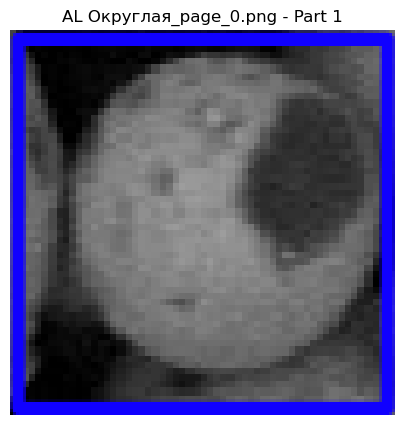

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_1_krug.png


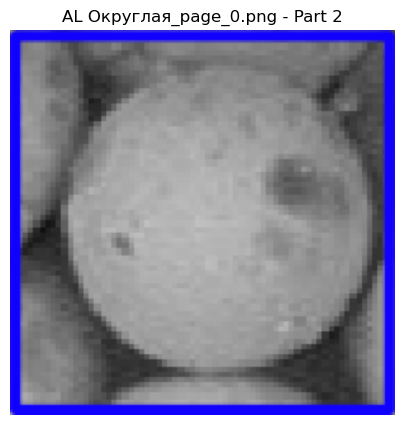

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_2_krug.png


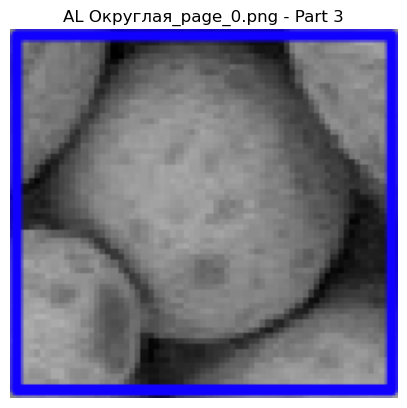

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_3_krug.png


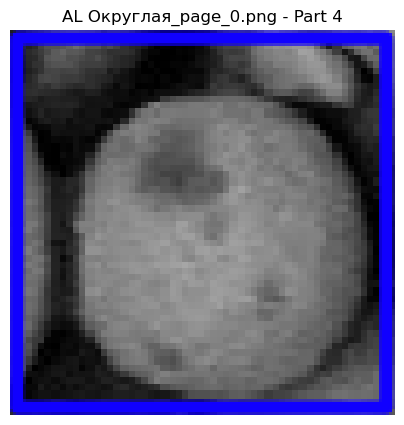

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_4_krug.png


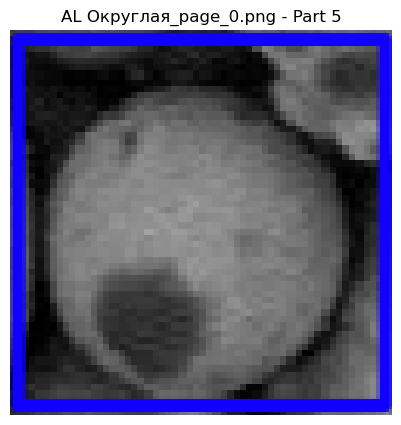

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_5_krug.png


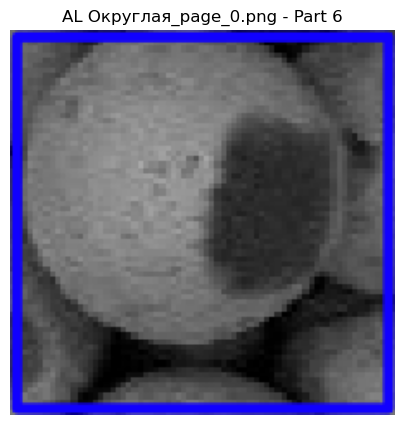

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_6_krug.png


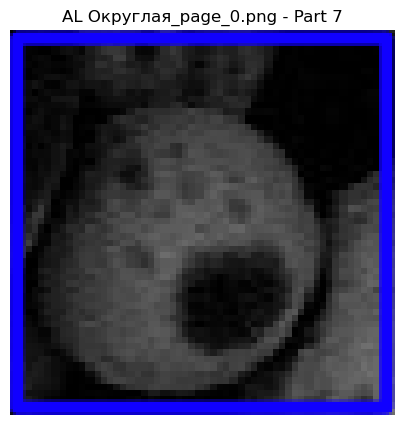

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_7_krug.png


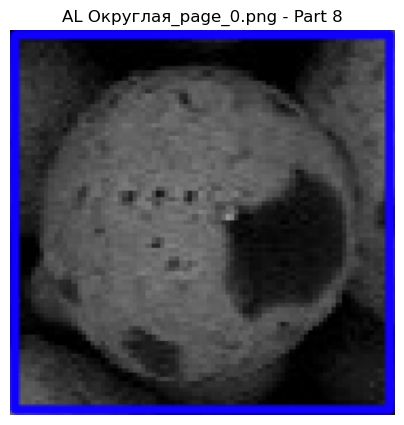

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_8_krug.png


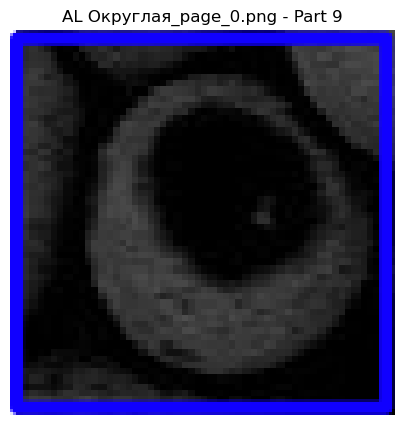

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_9_krug.png


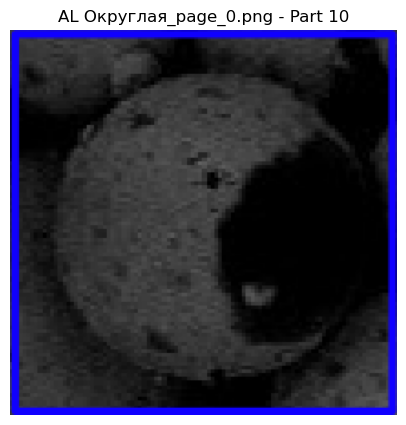

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\AL_10_krug.png


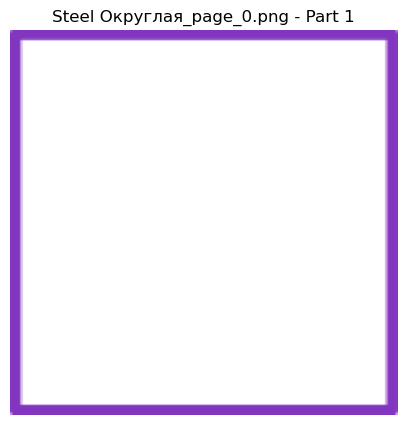

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_1_krug.png


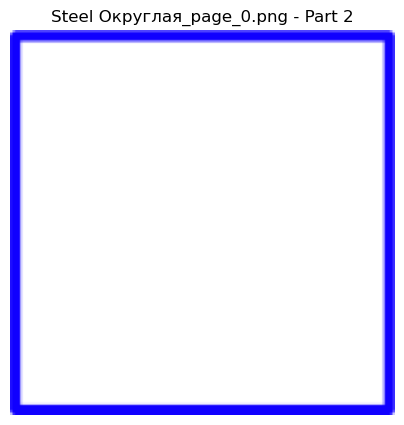

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_2_krug.png


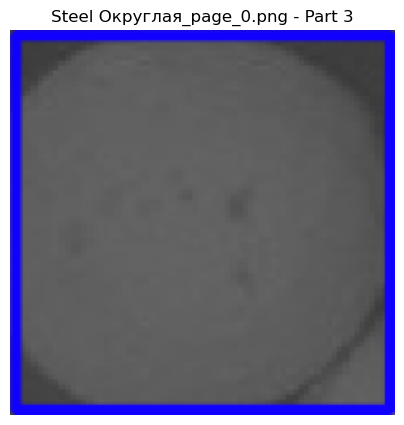

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_3_krug.png


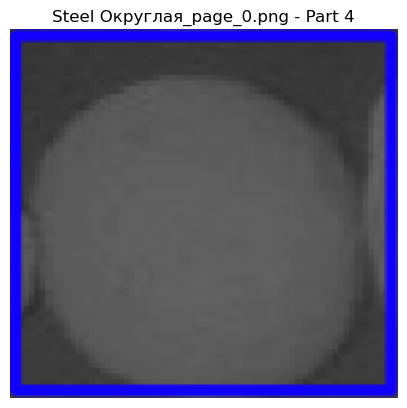

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_4_krug.png


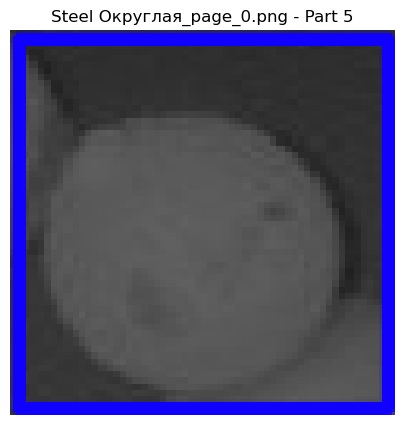

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_5_krug.png


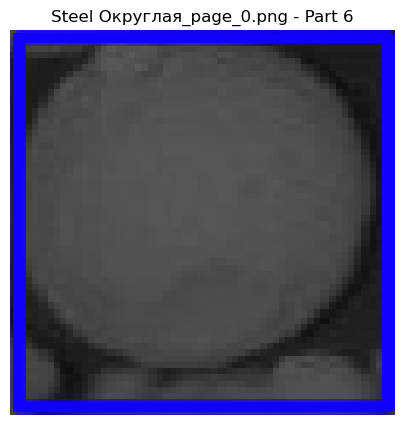

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_6_krug.png


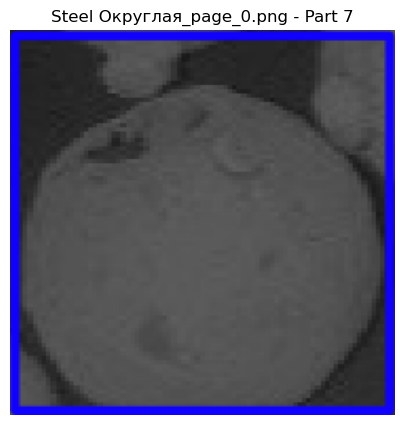

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_7_krug.png


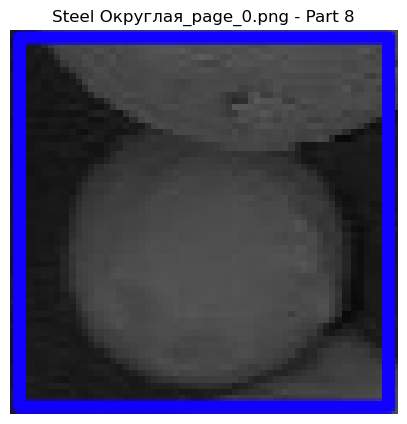

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_8_krug.png


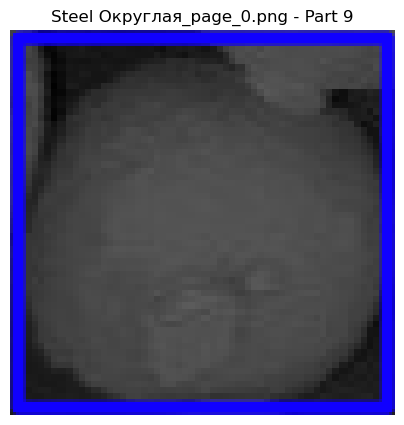

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_9_krug.png


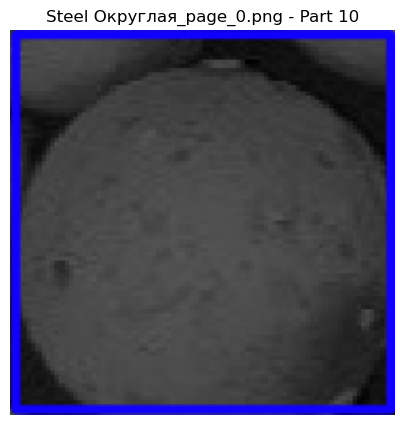

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_10_krug.png


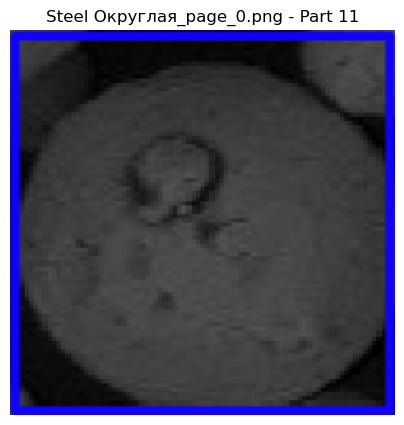

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_11_krug.png


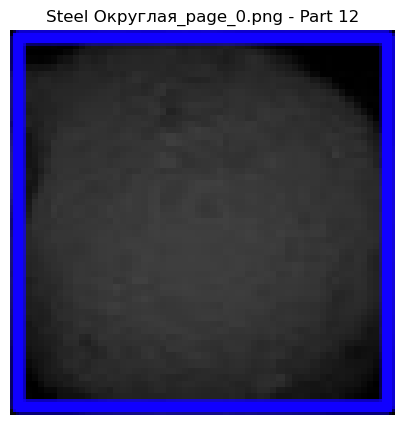

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\St_12_krug.png


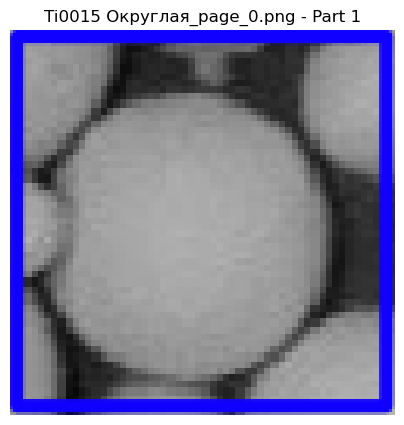

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_1_krug.png


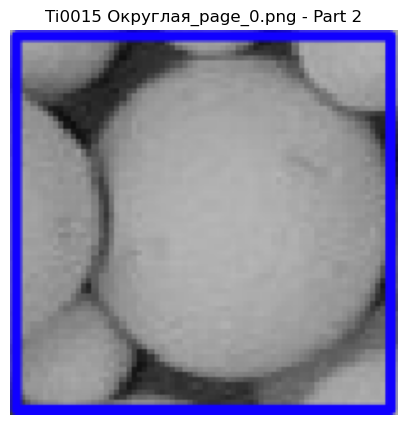

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_2_krug.png


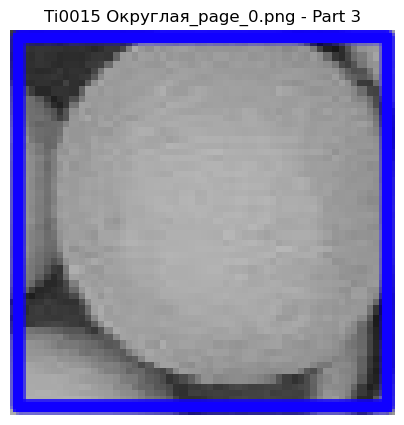

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_3_krug.png


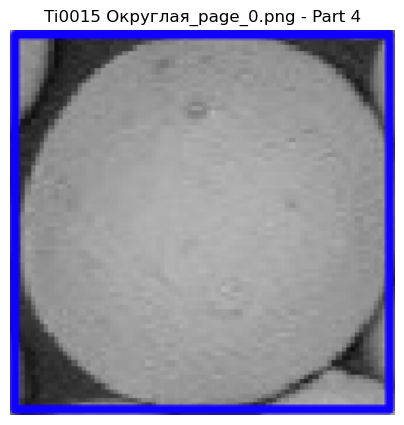

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_4_krug.png


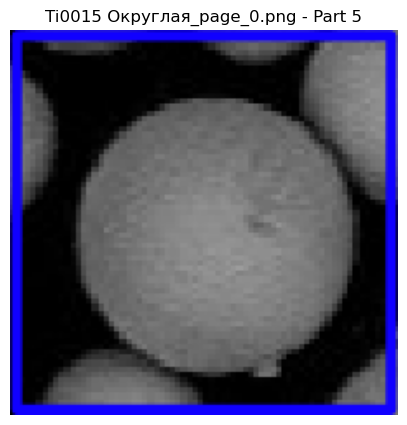

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_5_krug.png


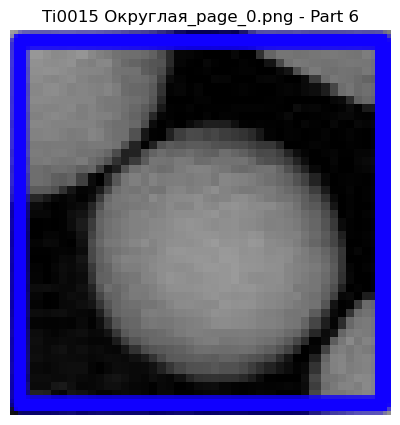

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_6_krug.png


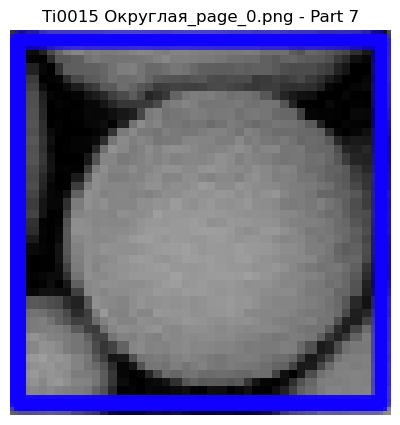

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_7_krug.png


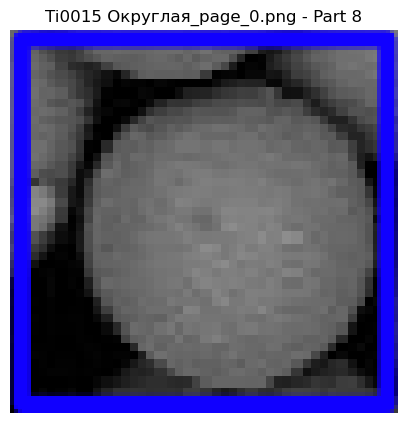

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_8_krug.png


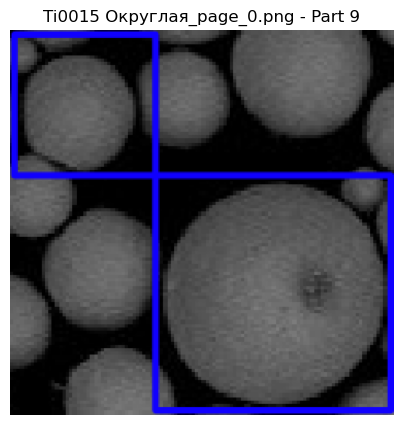

Saved: C:\Users\ivan\WORK\particles\class_png_parts_krug_new\Ti_9_krug.png
Processing complete!


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Для отображения изображений

# Define paths
source_folder = r"C:\Users\ivan\WORK\particles\class_png_new"
output_folder = r"C:\Users\ivan\WORK\particles\class_png_parts_krug_new"

# Helper function to find blue frameworks
def find_blue_frameworks(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for blue color in HSV
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])

    # Create mask for blue regions
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours (frameworks) in the blue mask
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

# Display function for debugging
def display_image(image, title="Image"):
    """Display an image using Matplotlib for debugging."""
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.title(title)
    plt.axis("off")
    plt.show()

# Process images in the source folder
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

for filename in os.listdir(source_folder):
    if filename.endswith(".png") and "Округлая" in filename:
        filepath = os.path.join(source_folder, filename)
        
        # Check if the file exists
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            continue
        
        # Read the image using imdecode (for better handling of Unicode paths)
        with open(filepath, "rb") as f:
            file_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
        image = cv2.imdecode(file_data, cv2.IMREAD_COLOR)
        
        if image is None:
            print(f"Failed to process: {filepath}")
            continue

        # Find blue frameworks in the image
        contours = find_blue_frameworks(image)
        
        # Process each blue framework (blue contour)
        for idx, contour in enumerate(contours):
            # Get bounding box around each blue framework
            x, y, w, h = cv2.boundingRect(contour)
            
            # Crop the part of the image that corresponds to the framework
            cropped_part = image[y:y+h, x:x+w]
            
            # Check if the cropped part is valid
            if cropped_part.shape[0] == 0 or cropped_part.shape[1] == 0:
                print(f"Invalid cropped part for {filename}, part {idx+1}. Skipping.")
                continue
            
            # Debug: Display the cropped part before saving
            display_image(cropped_part, title=f"{filename} - Part {idx+1}")
            
            # Generate output filename with part number
            output_filename = f"{filename[:2]}_{idx+1}_krug.png"  # First two letters of filename
            output_filepath = os.path.join(output_folder, output_filename)
            
            # Save the cropped part of the image
            success = cv2.imwrite(output_filepath, cropped_part)
            if success:
                print(f"Saved: {output_filepath}")
            else:
                print(f"Failed to save: {output_filepath}")

print("Processing complete!")


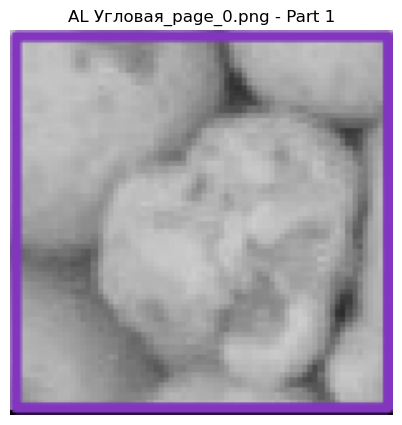

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_1_uglov.png


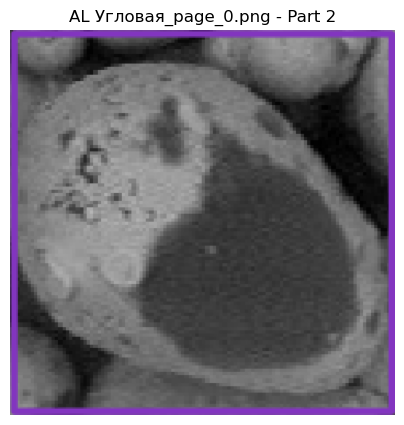

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_2_uglov.png


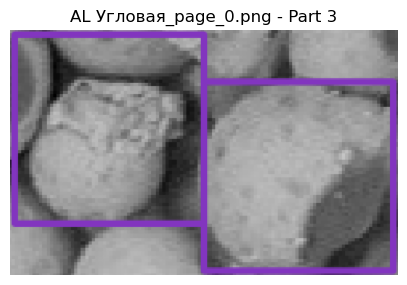

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_3_uglov.png


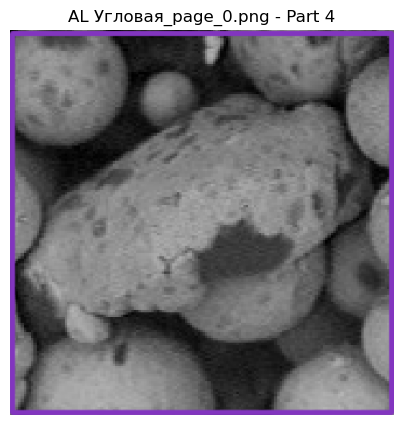

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_4_uglov.png


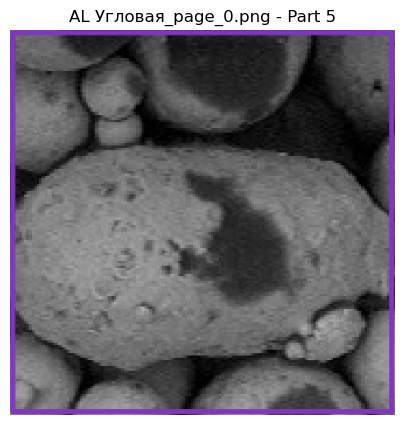

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_5_uglov.png


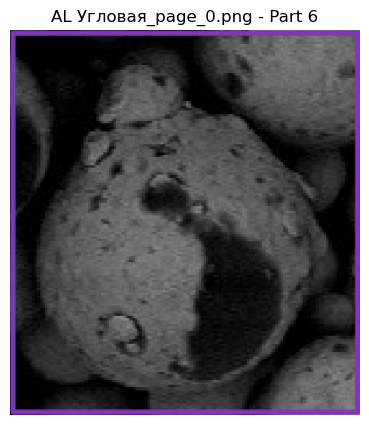

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_6_uglov.png


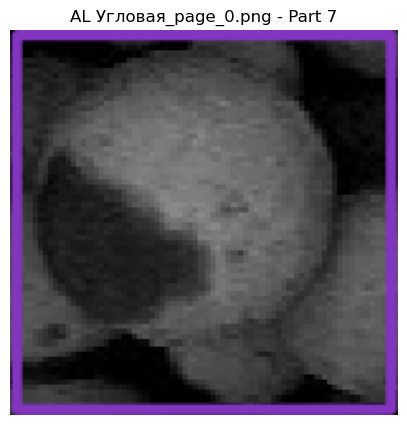

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_7_uglov.png


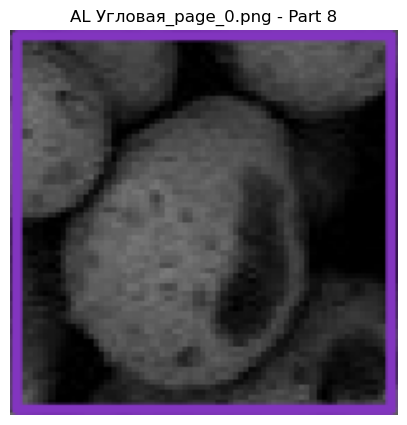

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_8_uglov.png


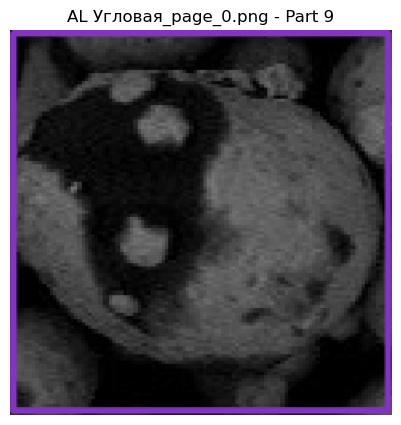

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\AL_9_uglov.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\St_1_uglov.png


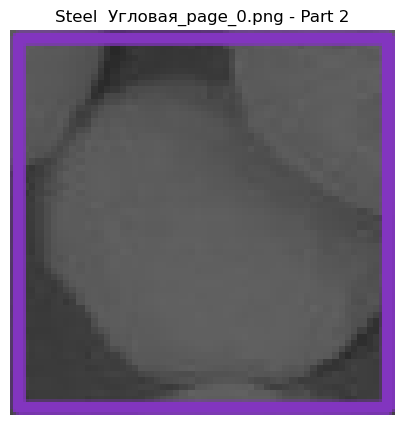

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\St_2_uglov.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\St_3_uglov.png


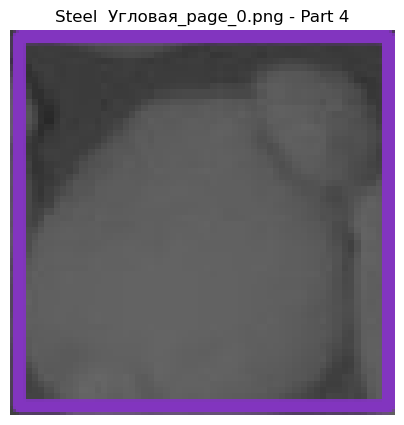

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\St_4_uglov.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\St_5_uglov.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\St_6_uglov.png


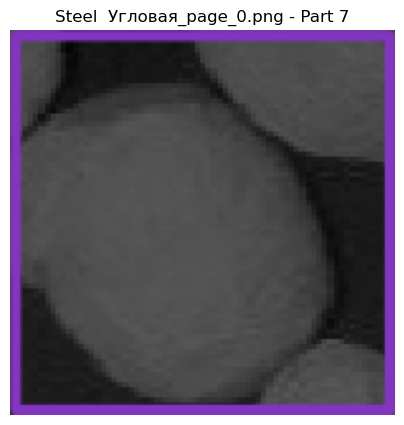

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\St_7_uglov.png


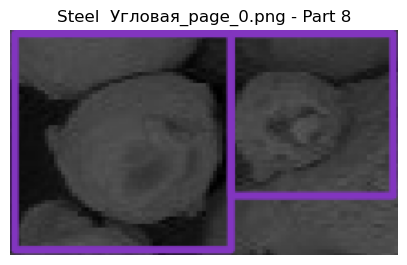

Saved: C:\Users\ivan\WORK\particles\class_png_parts_uglov_new\St_8_uglov.png
Processing complete!


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Для отображения изображений

# Define paths
source_folder = r"C:\Users\ivan\WORK\particles\class_png_new"
output_folder = r"C:\Users\ivan\WORK\particles\class_png_parts_uglov_new"

# Helper function to find purple frameworks
def find_purple_frameworks(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for purple color in HSV
    lower_purple = np.array([130, 50, 50])
    upper_purple = np.array([160, 255, 255])

    # Create mask for purple regions
    purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)

    # Find contours (frameworks) in the purple mask
    contours, _ = cv2.findContours(purple_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

# Display function for debugging
def display_image(image, title="Image"):
    """Display an image using Matplotlib for debugging."""
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.title(title)
    plt.axis("off")
    plt.show()

# Process images in the source folder
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

for filename in os.listdir(source_folder):
    if filename.endswith(".png") and "Угловая" in filename:
        filepath = os.path.join(source_folder, filename)
        
        # Check if the file exists
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            continue
        
        # Read the image using imdecode (for better handling of Unicode paths)
        with open(filepath, "rb") as f:
            file_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
        image = cv2.imdecode(file_data, cv2.IMREAD_COLOR)
        
        if image is None:
            print(f"Failed to process: {filepath}")
            continue

        # Find purple frameworks in the image
        contours = find_purple_frameworks(image)
        
        # Process each purple framework (purple contour)
        for idx, contour in enumerate(contours):
            # Get bounding box around each purple framework
            x, y, w, h = cv2.boundingRect(contour)
            
            # Crop the part of the image that corresponds to the framework
            cropped_part = image[y:y+h, x:x+w]
            
            # Check if the cropped part is valid
            if cropped_part.shape[0] == 0 or cropped_part.shape[1] == 0:
                print(f"Invalid cropped part for {filename}, part {idx+1}. Skipping.")
                continue
            
            # Debug: Display the cropped part before saving
            display_image(cropped_part, title=f"{filename} - Part {idx+1}")
            
            # Generate output filename with part number
            output_filename = f"{filename[:2]}_{idx+1}_uglov.png"  # First two letters of filename
            output_filepath = os.path.join(output_folder, output_filename)
            
            # Save the cropped part of the image
            success = cv2.imwrite(output_filepath, cropped_part)
            if success:
                print(f"Saved: {output_filepath}")
            else:
                print(f"Failed to save: {output_filepath}")

print("Processing complete!")


Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_1_bryzgi.png


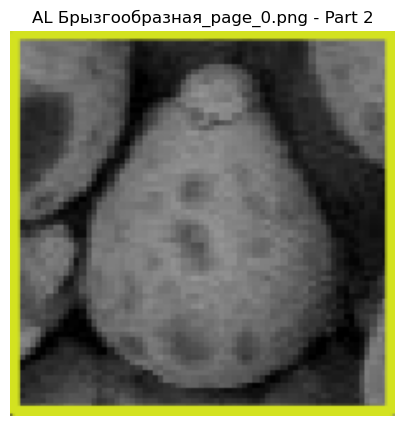

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_2_bryzgi.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_3_bryzgi.png


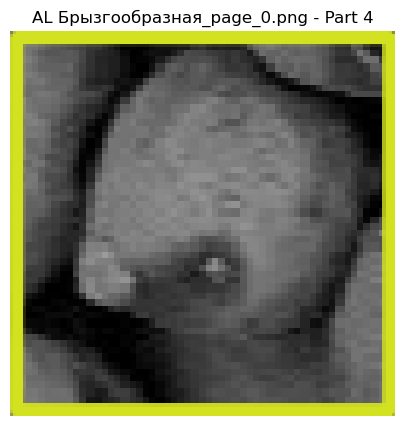

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_4_bryzgi.png


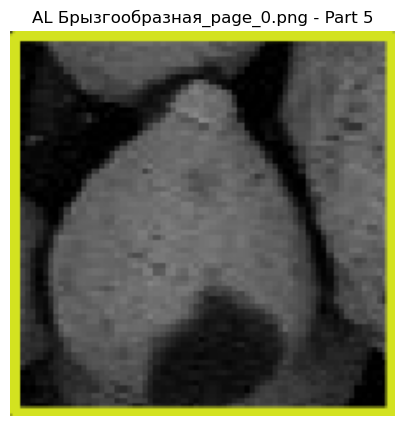

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_5_bryzgi.png


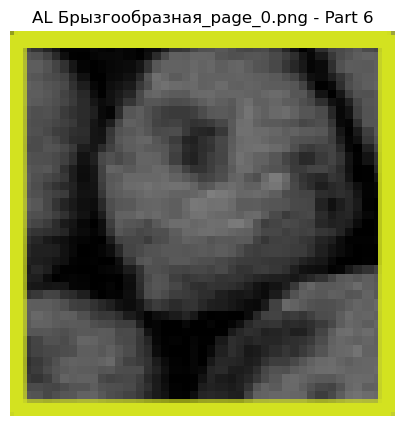

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_6_bryzgi.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_7_bryzgi.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_8_bryzgi.png


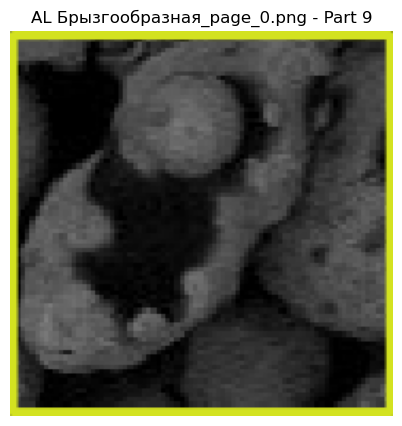

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_9_bryzgi.png


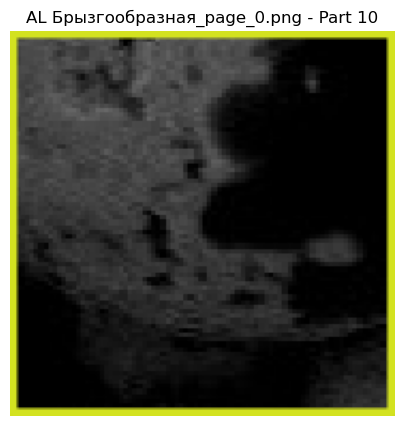

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_10_bryzgi.png


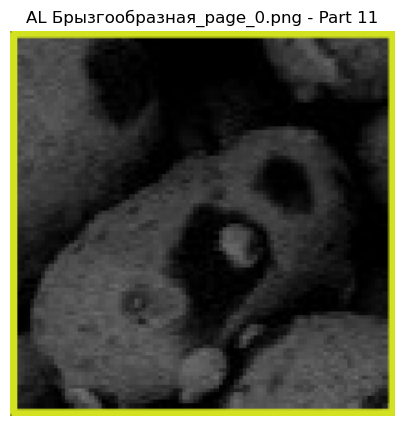

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_11_bryzgi.png


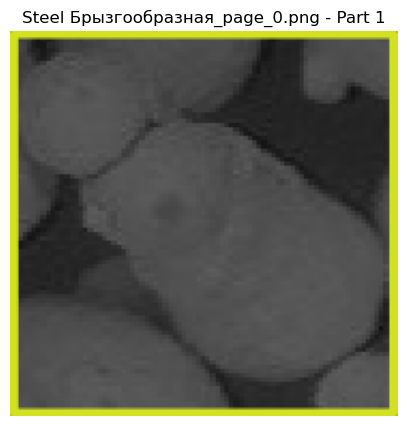

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_1_bryzgi.png


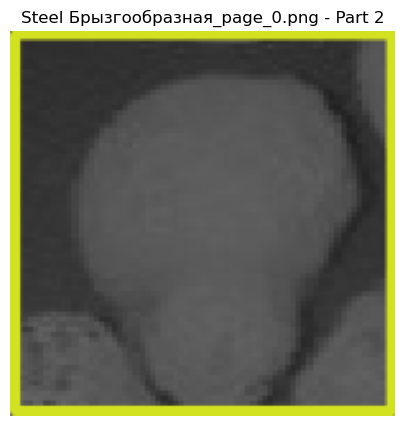

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_2_bryzgi.png


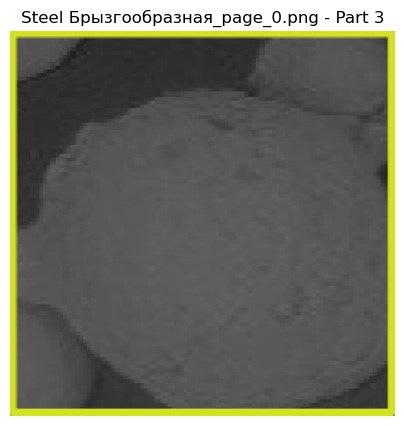

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_3_bryzgi.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_4_bryzgi.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_5_bryzgi.png


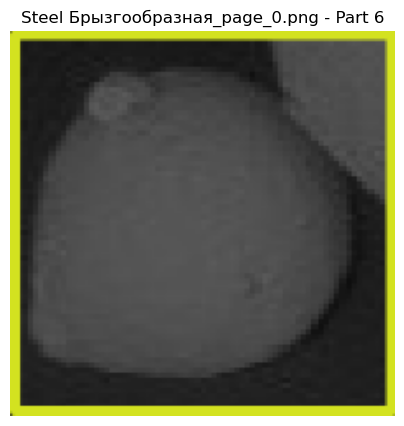

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_6_bryzgi.png


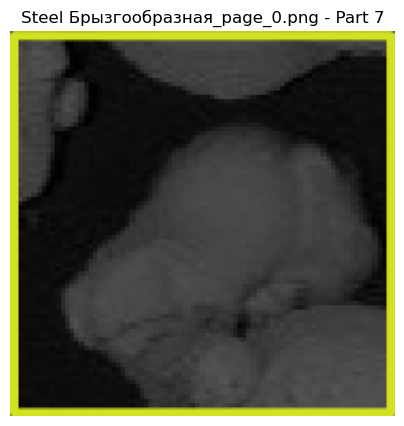

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_7_bryzgi.png


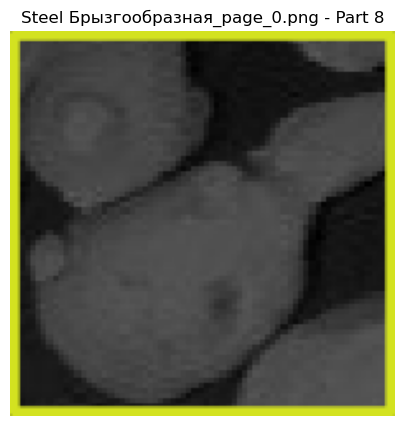

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_8_bryzgi.png


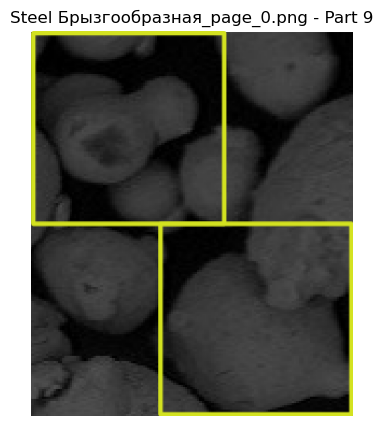

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\St_9_bryzgi.png


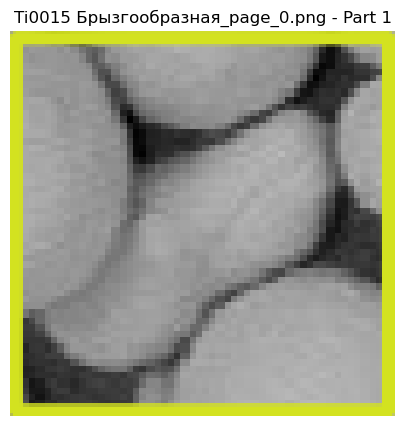

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_1_bryzgi.png


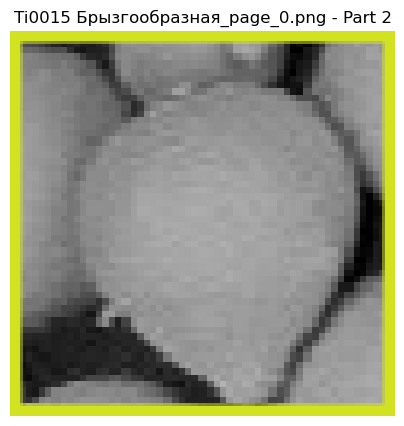

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_2_bryzgi.png


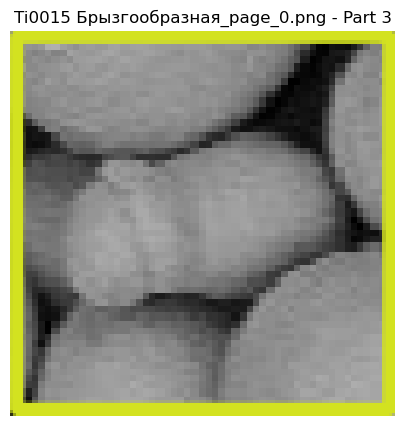

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_3_bryzgi.png


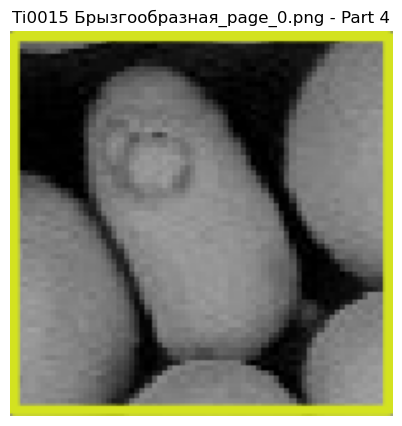

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_4_bryzgi.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_5_bryzgi.png


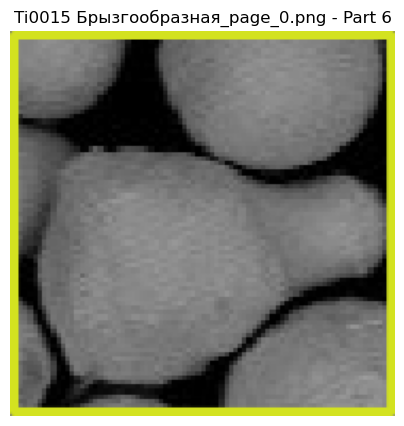

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_6_bryzgi.png


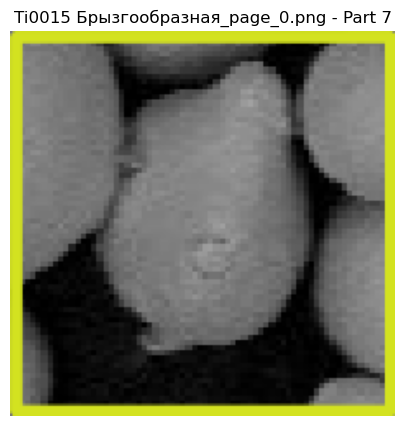

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_7_bryzgi.png


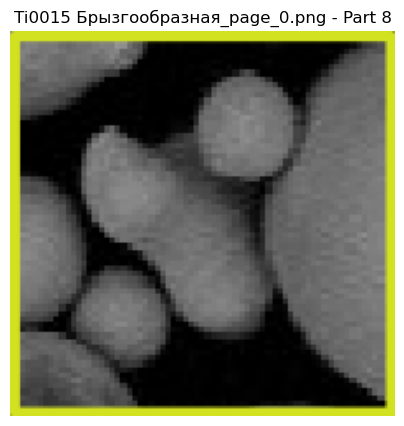

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_8_bryzgi.png


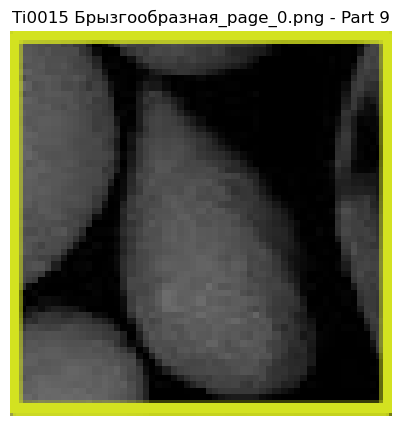

Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\Ti_9_bryzgi.png
Processing complete!


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Для отображения изображений

# Define paths
source_folder = r"C:\Users\ivan\WORK\particles\class_png_new"
output_folder = r"C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new"

# Helper function to find yellow frameworks
def find_yellow_frameworks(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for yellow color in HSV
    lower_yellow = np.array([20, 200, 200])
    upper_yellow = np.array([35, 230, 235])
     #32., 219., 226.

    # Create mask for yellow regions
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Find contours (frameworks) in the yellow mask
    contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

# Display function for debugging
def display_image(image, title="Image"):
    """Display an image using Matplotlib for debugging."""
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.title(title)
    plt.axis("off")
    plt.show()

# Process images in the source folder
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

for filename in os.listdir(source_folder):
    if filename.endswith(".png") and "Брызгообразная" in filename:  # Case insensitive
        filepath = os.path.join(source_folder, filename)
        
        # Check if the file exists
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            continue
        
        # Read the image using imdecode (for better handling of Unicode paths)
        with open(filepath, "rb") as f:
            file_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
        image = cv2.imdecode(file_data, cv2.IMREAD_COLOR)
        
        if image is None:
            print(f"Failed to process: {filepath}")
            continue

        # Find yellow frameworks in the image
        contours = find_yellow_frameworks(image)
        
        # Process each yellow framework (yellow contour)
        for idx, contour in enumerate(contours):
            # Get bounding box around each yellow framework
            x, y, w, h = cv2.boundingRect(contour)
            
            # Crop the part of the image that corresponds to the framework
            cropped_part = image[y:y+h, x:x+w]
            
            # Check if the cropped part is valid
            if cropped_part.shape[0] == 0 or cropped_part.shape[1] == 0:
                print(f"Invalid cropped part for {filename}, part {idx+1}. Skipping.")
                continue
            
            # Debug: Display the cropped part before saving
            display_image(cropped_part, title=f"{filename} - Part {idx+1}")
            
            # Generate output filename with part number
            output_filename = f"{filename[:2]}_{idx+1}_bryzgi.png"  # First two letters of filename
            output_filepath = os.path.join(output_folder, output_filename)
            
            # Save the cropped part of the image
            success = cv2.imwrite(output_filepath, cropped_part)
            if success:
                print(f"Saved: {output_filepath}")
            else:
                print(f"Failed to save: {output_filepath}")

print("Processing complete!")


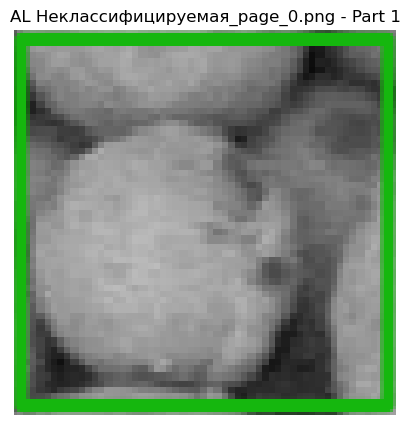

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_1_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_2_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_3_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_4_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_5_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_6_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_7_nekclass.png


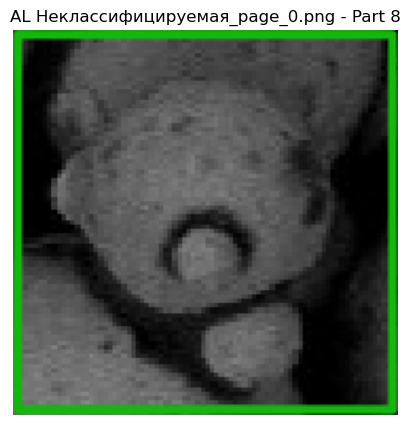

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_8_nekclass.png


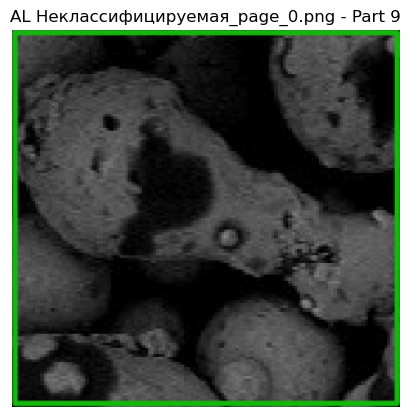

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_9_nekclass.png


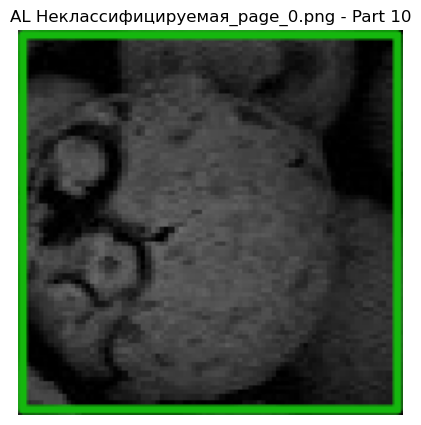

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\AL_10_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_1_nekclass.png


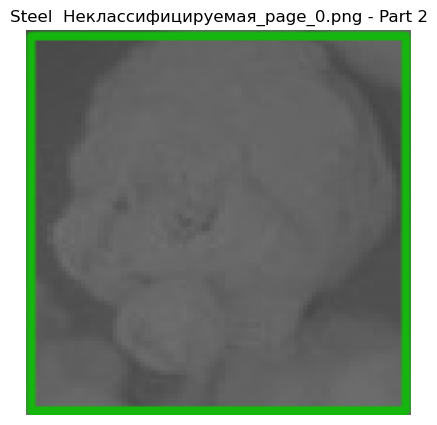

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_2_nekclass.png


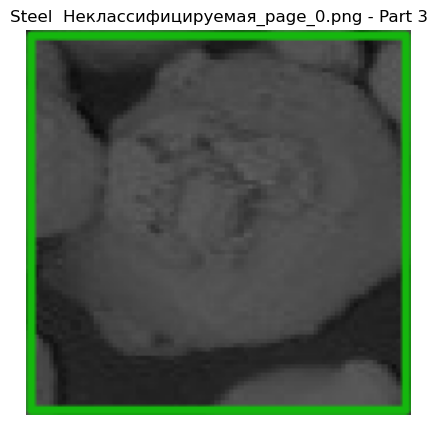

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_3_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_4_nekclass.png


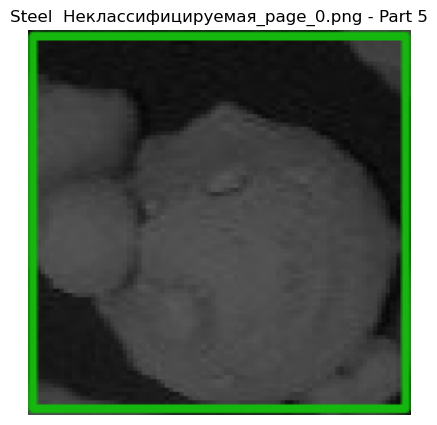

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_5_nekclass.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_6_nekclass.png


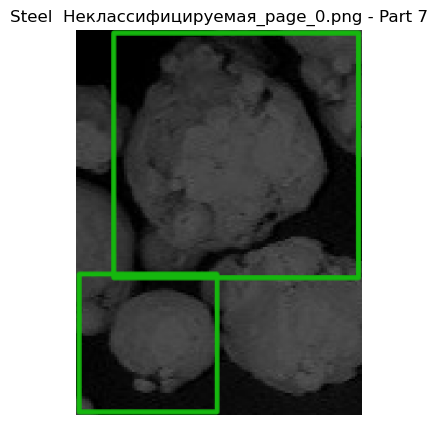

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_7_nekclass.png


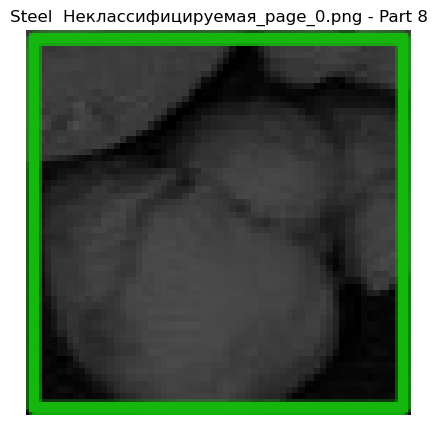

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_8_nekclass.png


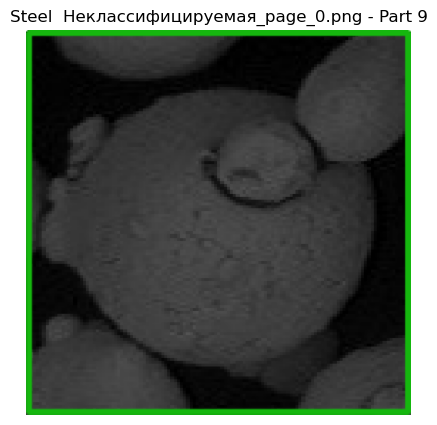

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\St_9_nekclass.png


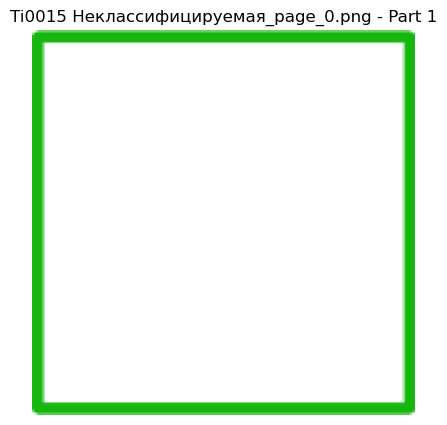

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_1_nekclass.png


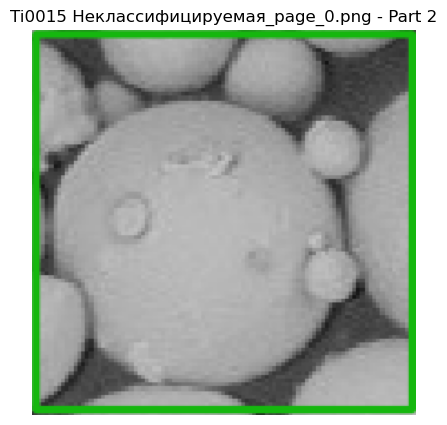

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_2_nekclass.png


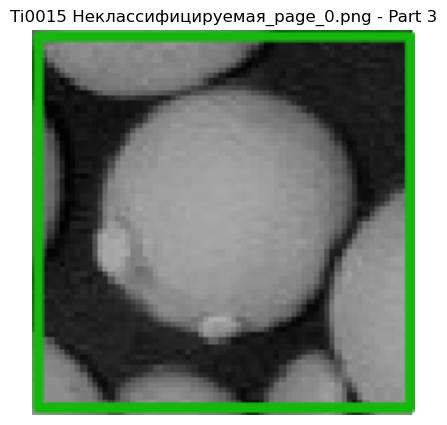

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_3_nekclass.png


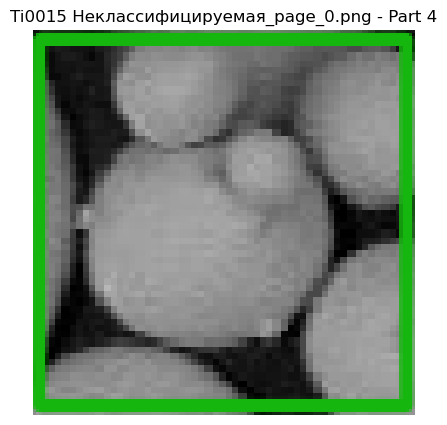

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_4_nekclass.png


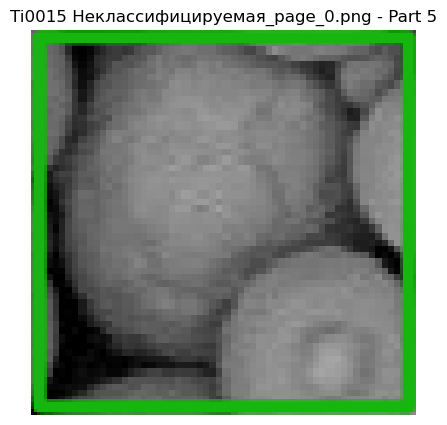

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_5_nekclass.png


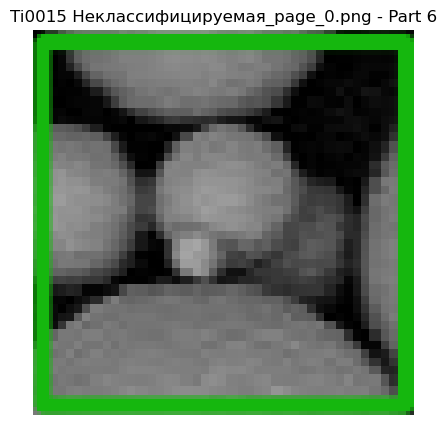

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_6_nekclass.png


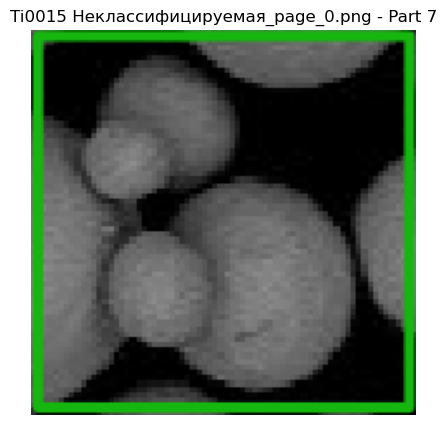

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_7_nekclass.png


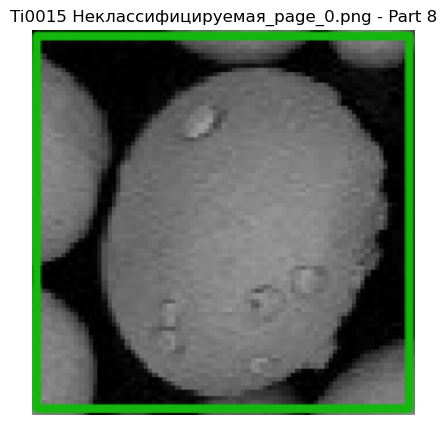

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_8_nekclass.png


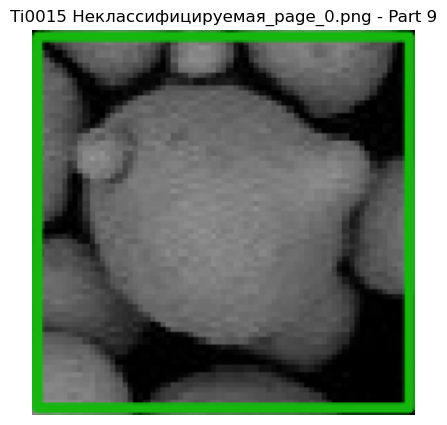

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_9_nekclass.png


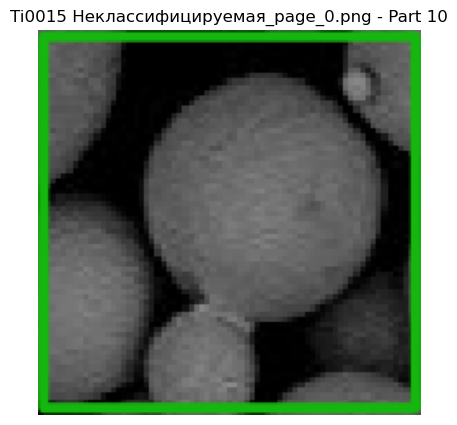

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_10_nekclass.png


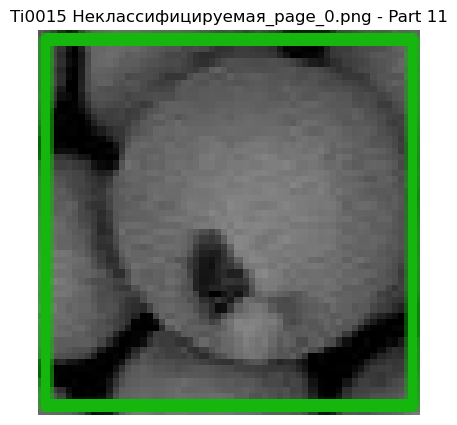

Saved: C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new\Ti_11_nekclass.png
Processing complete!


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Для отображения изображений

# Define paths
source_folder = r"C:\Users\ivan\WORK\particles\class_png_new"
output_folder = r"C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new"

# Helper function to find green frameworks
def find_green_frameworks(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for green color in HSV
    lower_green = np.array([40, 50, 50])
    upper_green = np.array([80, 255, 255])

    # Create mask for green regions
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Find contours (frameworks) in the green mask
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

# Display function for debugging
def display_image(image, title="Image"):
    """Display an image using Matplotlib for debugging."""
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.title(title)
    plt.axis("off")
    plt.show()

# Process images in the source folder
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

for filename in os.listdir(source_folder):
    if filename.endswith(".png") and "Неклассифицируемая" in filename:
        filepath = os.path.join(source_folder, filename)
        
        # Check if the file exists
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            continue
        
        # Read the image using imdecode (for better handling of Unicode paths)
        with open(filepath, "rb") as f:
            file_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
        image = cv2.imdecode(file_data, cv2.IMREAD_COLOR)
        
        if image is None:
            print(f"Failed to process: {filepath}")
            continue

        # Find green frameworks in the image
        contours = find_green_frameworks(image)
        
        # Process each green framework (green contour)
        for idx, contour in enumerate(contours):
            # Get bounding box around each green framework
            x, y, w, h = cv2.boundingRect(contour)
            
            # Crop the part of the image that corresponds to the framework
            cropped_part = image[y:y+h, x:x+w]
            
            # Check if the cropped part is valid
            if cropped_part.shape[0] == 0 or cropped_part.shape[1] == 0:
                print(f"Invalid cropped part for {filename}, part {idx+1}. Skipping.")
                continue
            
            # Debug: Display the cropped part before saving
            display_image(cropped_part, title=f"{filename} - Part {idx+1}")
            
            # Generate output filename with part number
            output_filename = f"{filename[:2]}_{idx+1}_nekclass.png"  # First two letters of filename
            output_filepath = os.path.join(output_folder, output_filename)
            
            # Save the cropped part of the image
            success = cv2.imwrite(output_filepath, cropped_part)
            if success:
                print(f"Saved: {output_filepath}")
            else:
                print(f"Failed to save: {output_filepath}")

print("Processing complete!")


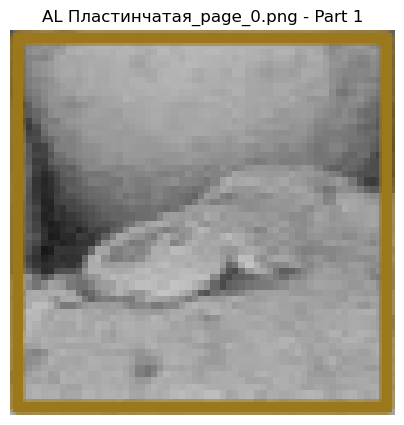

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_1_plast.png


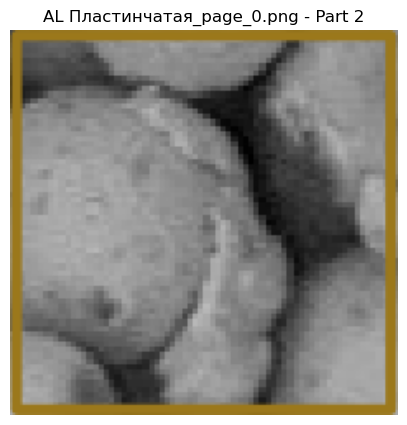

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_2_plast.png


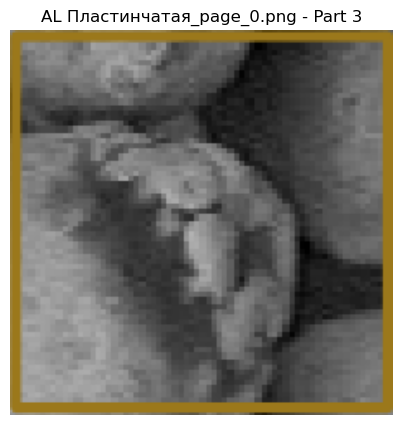

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_3_plast.png


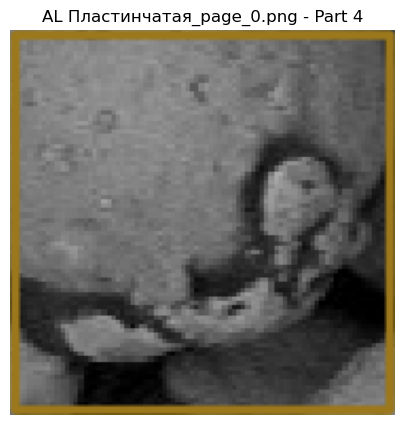

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_4_plast.png


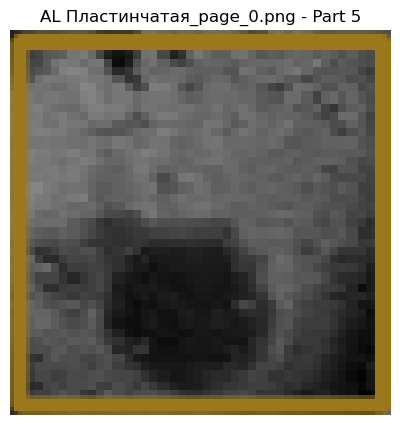

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_5_plast.png


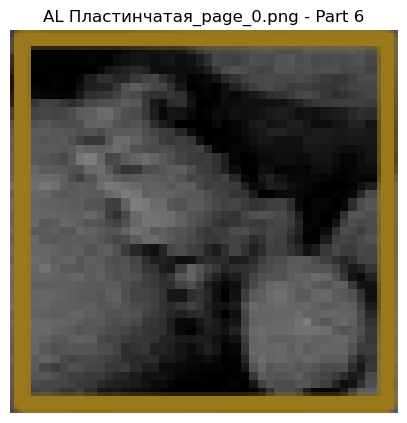

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_6_plast.png


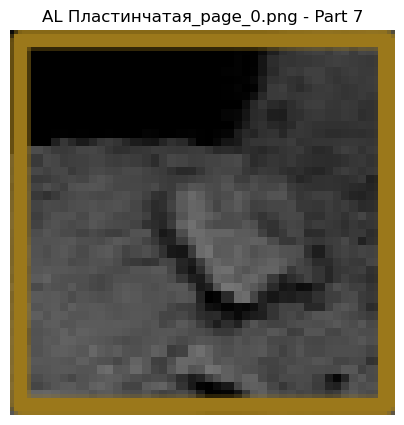

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_7_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_8_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_9_plast.png


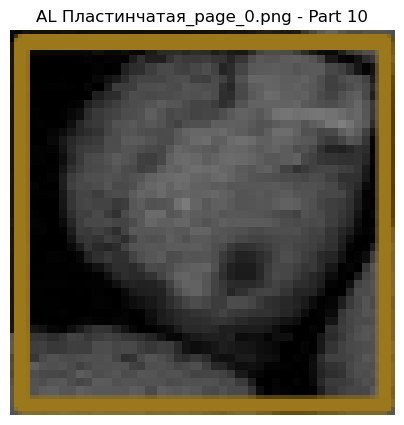

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\AL_10_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_1_plast.png


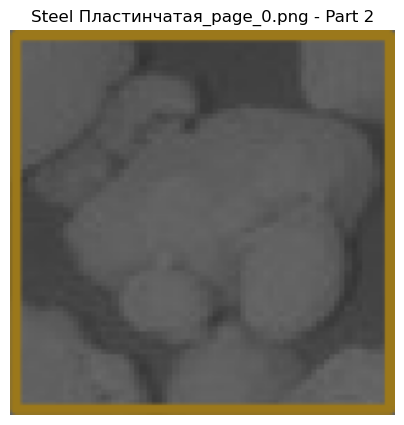

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_2_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_3_plast.png


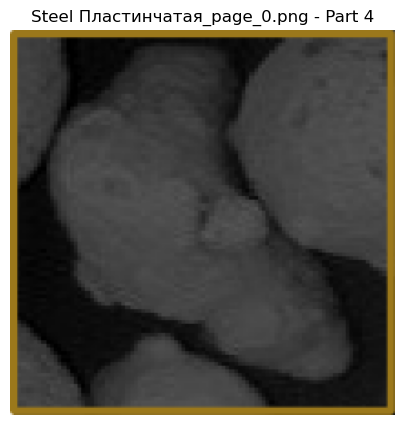

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_4_plast.png


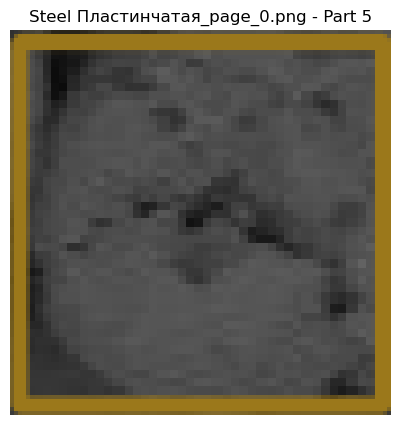

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_5_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_6_plast.png


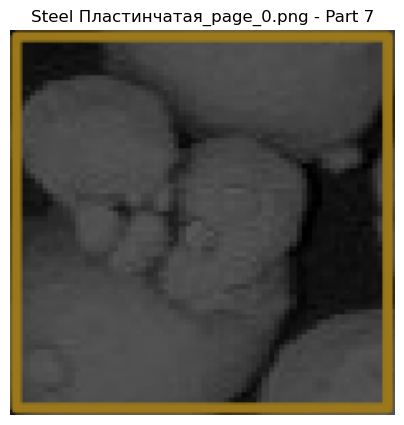

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_7_plast.png


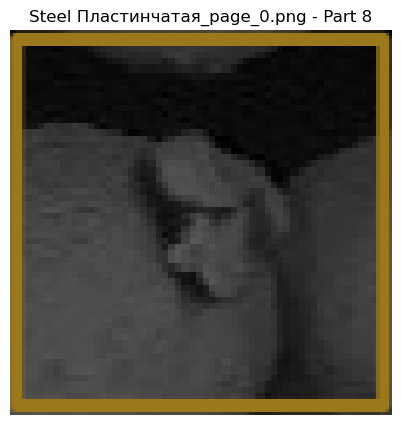

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_8_plast.png


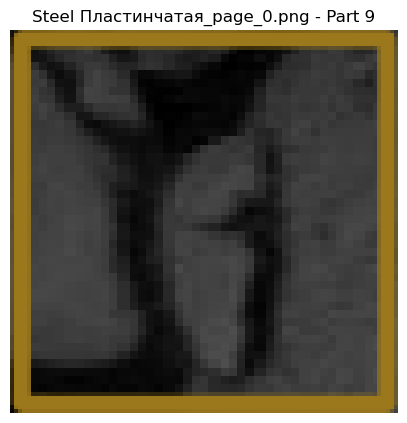

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_9_plast.png


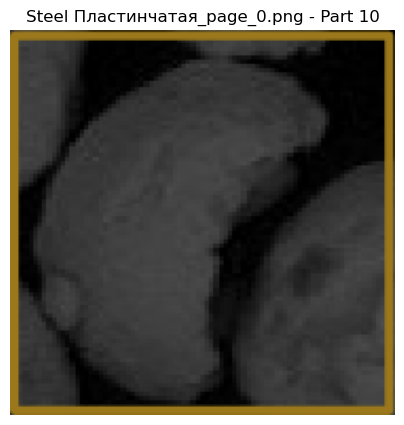

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\St_10_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_1_plast.png


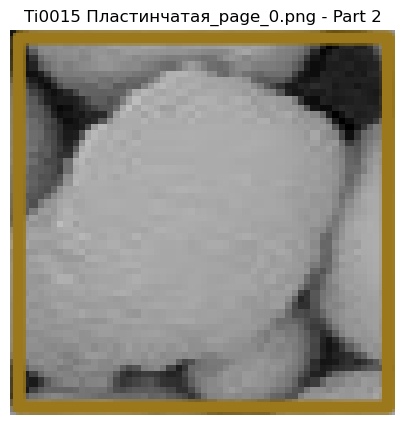

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_2_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_3_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_4_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_5_plast.png


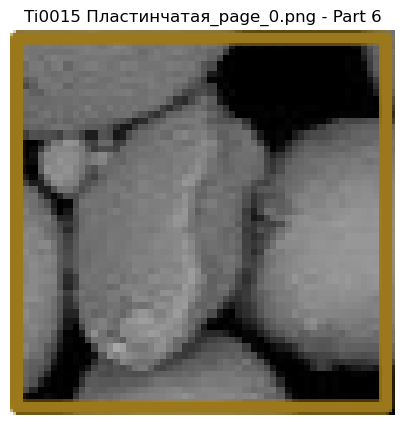

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_6_plast.png


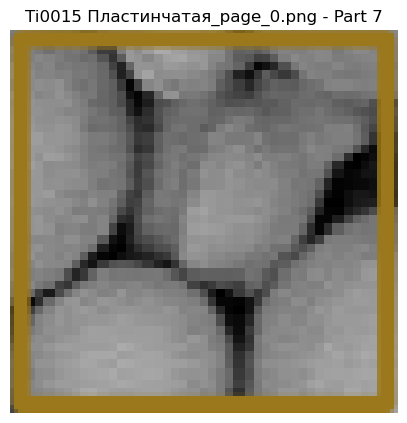

Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_7_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_8_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_9_plast.png


Saved: C:\Users\ivan\WORK\particles\class_png_parts_plast_new\Ti_10_plast.png
Processing complete!


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Для отображения изображений

# Define paths
source_folder = r"C:\Users\ivan\WORK\particles\class_png_new"
output_folder = r"C:\Users\ivan\WORK\particles\class_png_parts_plast_new"

# Helper function to find brown frameworks
def find_brown_frameworks(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for brown color in HSV
    lower_brown = np.array([20, 50, 50])
    upper_brown = np.array([30, 255, 200])

#     [18, 150, 100]
#Верхняя граница: [26, 255, 200]
    # Create mask for brown regions
    brown_mask = cv2.inRange(hsv, lower_brown, upper_brown)

    # Find contours (frameworks) in the brown mask
    contours, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

# Display function for debugging
def display_image(image, title="Image"):
    """Display an image using Matplotlib for debugging."""
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.title(title)
    plt.axis("off")
    plt.show()

# Process images in the source folder
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

for filename in os.listdir(source_folder):
    if filename.endswith(".png") and "Пластинчатая" in filename:
        filepath = os.path.join(source_folder, filename)
        
        # Check if the file exists
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            continue
        
        # Read the image using imdecode (for better handling of Unicode paths)
        with open(filepath, "rb") as f:
            file_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
        image = cv2.imdecode(file_data, cv2.IMREAD_COLOR)
        
        if image is None:
            print(f"Failed to process: {filepath}")
            continue

        # Find brown frameworks in the image
        contours = find_brown_frameworks(image)
        
        # Process each brown framework (brown contour)
        for idx, contour in enumerate(contours):
            # Get bounding box around each brown framework
            x, y, w, h = cv2.boundingRect(contour)
            
            # Crop the part of the image that corresponds to the framework
            cropped_part = image[y:y+h, x:x+w]
            
            # Check if the cropped part is valid
            if cropped_part.shape[0] == 0 or cropped_part.shape[1] == 0:
                print(f"Invalid cropped part for {filename}, part {idx+1}. Skipping.")
                continue
            
            # Debug: Display the cropped part before saving
            display_image(cropped_part, title=f"{filename} - Part {idx+1}")
            
            # Generate output filename with part number
            output_filename = f"{filename[:2]}_{idx+1}_plast.png"  # First two letters of filename
            output_filepath = os.path.join(output_folder, output_filename)
            
            # Save the cropped part of the image
            success = cv2.imwrite(output_filepath, cropped_part)
            if success:
                print(f"Saved: {output_filepath}")
            else:
                print(f"Failed to save: {output_filepath}")

print("Processing complete!")


In [11]:
import os
import cv2
import numpy as np

# Define source and destination folders
source_folders = [
    r"C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new",   # Брызгообразная
    r"C:\Users\ivan\WORK\particles\class_png_parts_dendr_new",    # Дендритная
    r"C:\Users\ivan\WORK\particles\class_png_parts_krug_new",     # Округлая
    r"C:\Users\ivan\WORK\particles\class_png_parts_nekclass_new", # Неклассифицируемая
    r"C:\Users\ivan\WORK\particles\class_png_parts_plast_new",    # Пластинчатая
    r"C:\Users\ivan\WORK\particles\class_png_parts_uglov_new",    # Угловая
]

# Define output folder for cropped images
output_folders = [
    r"C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_cropped_new",
    r"C:\Users\ivan\WORK\particles\class_png_parts_dendr_cropped_new",
    r"C:\Users\ivan\WORK\particles\class_png_parts_krug_cropped_new",
    r"C:\Users\ivan\WORK\particles\class_png_parts_nekclass_cropped_new",
    r"C:\Users\ivan\WORK\particles\class_png_parts_plast_cropped_new",
    r"C:\Users\ivan\WORK\particles\class_png_parts_uglov_cropped_new",
]

# Define color ranges for each frame type (in HSV)
color_boundaries = {
    'bryzgi': (np.array([20, 200, 200]), np.array([35, 230, 235])),  # Брызгообразная (yellow)
    'dendr': (np.array([0, 70, 50]), np.array([10, 255, 255])),      # Дендритная (red range 1)
    'krug': (np.array([100, 150, 50]), np.array([140, 255, 255])),    # Округлая (blue)
    'nekclass': (np.array([40, 50, 50]), np.array([80, 255, 255])),   # Неклассифицируемая (green)
    'plast': (np.array([20, 50, 50]), np.array([30, 255, 200])),     # Пластинчатая (brown)
    'uglov': (np.array([100, 150, 50]), np.array([140, 255, 255])),  # Угловая (blue)
}

# Function to remove color frame from image
def remove_frame(image, lower_bound, upper_bound):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create mask for the target color (frame)
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Set the pixels corresponding to the mask to white (or any background color)
    image[mask != 0] = [255, 255, 255]  # White background for removed frame
    return image

# Process each folder and each image inside
for source_folder, output_folder in zip(source_folders, output_folders):
    # Print the folder being processed for diagnostics
    print(f"Processing folder: {source_folder}")
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # List all files in the source folder
    for filename in os.listdir(source_folder):
        if filename.endswith(".png"):
            filepath = os.path.join(source_folder, filename)
            output_filepath = os.path.join(output_folder, filename)

            # Read the image using cv2
            image = cv2.imread(filepath)

            # Check if the image was loaded properly
            if image is None:
                print(f"Failed to load image: {filepath}")
                continue
            else:
                print(f"Successfully loaded image: {filepath}")

            # Determine the color frame to remove based on the filename
            if 'bryzgi' in filename.lower():
                lower_bound, upper_bound = color_boundaries['bryzgi']
            elif 'krug' in filename.lower():
                lower_bound, upper_bound = color_boundaries['krug']
            elif 'dendr' in filename.lower():
                lower_bound, upper_bound = color_boundaries['dendr']
            elif 'nekclass' in filename.lower():
                lower_bound, upper_bound = color_boundaries['nekclass']
            elif 'plast' in filename.lower():
                lower_bound, upper_bound = color_boundaries['plast']
            elif 'uglov' in filename.lower():
                lower_bound, upper_bound = color_boundaries['uglov']
            else:
                print(f"Unknown type for file: {filename}. Skipping...")
                continue

            # Remove the frame color from the image
            cropped_image = remove_frame(image.copy(), lower_bound, upper_bound)

            # Save the cropped image to the output folder
            try:
                success = cv2.imwrite(output_filepath, cropped_image)
                if success:
                    print(f"Saved: {output_filepath}")
                else:
                    print(f"Failed to save: {output_filepath}")
            except Exception as e:
                print(f"Error saving image {output_filepath}: {e}")

print("Processing complete!")


Processing folder: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new
Successfully loaded image: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_10_bryzgi.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_cropped_new\AL_10_bryzgi.png
Successfully loaded image: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_11_bryzgi.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_cropped_new\AL_11_bryzgi.png
Successfully loaded image: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_1_bryzgi.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_cropped_new\AL_1_bryzgi.png
Successfully loaded image: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_2_bryzgi.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_cropped_new\AL_2_bryzgi.png
Successfully loaded image: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_new\AL_3_bryzgi.png
Saved: C:\Users\ivan\WORK\particles\class_png_parts_bryzgi_cropped_new\AL_3_br

In [50]:
import os
from PIL import Image

# Исходная и новая директория
src_dir = r'C:\Users\ivan\WORK\particles\SEM'
dst_dir = r'C:\Users\ivan\WORK\particles\SEM_new'

# Функция для обрезки изображения на 100 пикселей снизу
def crop_bottom(image):
    width, height = image.size
    # Обрезаем изображение, исключив последние 100 пикселей
    cropped_image = image.crop((0, 0, width, height - 100))
    return cropped_image

# Функция для обработки всех изображений в директории и ее подпапках
def process_images(src_dir, dst_dir):
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if file.endswith('.jpg'):
                # Полный путь к исходному изображению
                src_image_path = os.path.join(root, file)
                
                # Определяем структуру папок в новой директории
                rel_path = os.path.relpath(root, src_dir)
                dst_folder = os.path.join(dst_dir, rel_path)
                
                # Создаем папку, если она не существует
                if not os.path.exists(dst_folder):
                    os.makedirs(dst_folder)

                # Путь для сохранения нового изображения
                dst_image_path = os.path.join(dst_folder, file)

                # Открываем изображение
                image = Image.open(src_image_path)

                # Обрезаем изображение
                cropped_image = crop_bottom(image)

                # Сохраняем изображение в новую папку
                cropped_image.save(dst_image_path)
                print(f"Сохранено: {dst_image_path}")

# Запуск обработки
process_images(src_dir, dst_dir)


Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0001.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0002.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0003.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0004.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0005.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0006.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0007.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0008.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0009.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0010.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0011.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0012.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0013.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0014.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Al\Al0015.jpg
Сохранено: C:\Users\ivan\WORK\particles\SEM_new\Steel\steel0001.jpg
Со